In [127]:
import sys
import pickle as pkl
import os

if os.getcwd().split('/')[-1] == 'trading':
    os.chdir('../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import linear_trading as lt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
path = './results/clusterings/2002-01-2002-03_PCA-3_SpectralClustering.pkl'
clusters = pkl.load(open(path, 'rb'))
clusters

[cluster
 0    [ABT, ADM, ADP, AGN, APD, ASH, ATI, AVP, AVY, ...
 1                                                 [HD]
 2                                                [DLX]
 Name: SpectralClustering_3, dtype: object,
 cluster
 0                                                [DLX]
 1                                                 [HD]
 2    [ABT, ADM, ADP, AGN, APD, ASH, ATI, AVP, AVY, ...
 3                                           [IBM, TXN]
 Name: SpectralClustering_5, dtype: object,
 cluster
 0                                                [DLX]
 1                                                 [HD]
 2                                           [CCK, MCK]
 3                                           [IBM, TXN]
 6    [ABT, ADM, ADP, AGN, APD, ASH, ATI, AVP, AVY, ...
 Name: SpectralClustering_7, dtype: object,
 cluster
 0                                                [DLX]
 1                                                 [HD]
 2    [ABT, ADM, ADP, AGN, APD, ASH, ATI, AVP, A

In [101]:
cluster = clusters[2]
cluster, len(cluster)

(cluster
 0                                                [DLX]
 1                                                 [HD]
 2                                           [CCK, MCK]
 3                                           [IBM, TXN]
 6    [ABT, ADM, ADP, AGN, APD, ASH, ATI, AVP, AVY, ...
 Name: SpectralClustering_7, dtype: object,
 5)

In [119]:
prices = pd.read_csv('./data/final_processed/daily_prices.csv', parse_dates=['date']).set_index('date')[['ticker','open']]
prices = prices.loc['2002-01-01':'2002-06-30']
prices  = prices.reset_index().set_index(['date', 'ticker']).stack()
prices.index = prices.index.droplevel(2)
prices = prices.unstack(1)
prices_norm = prices/ prices.iloc[0]

/var/folders/1t/_7p_zm4x449blqs7bvqvb0rm0000gn/T/ipykernel_59526/905018622.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  prices = prices.loc['2002-01-01':'2002-06-30']


0th cluster: 1
1th cluster: 1
2th cluster: 2
3th cluster: 2
4th cluster: 103


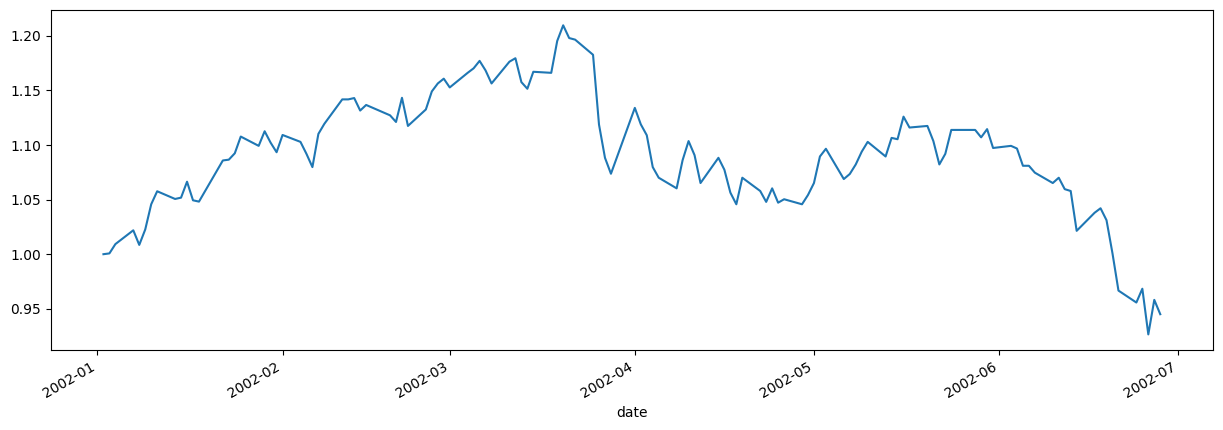

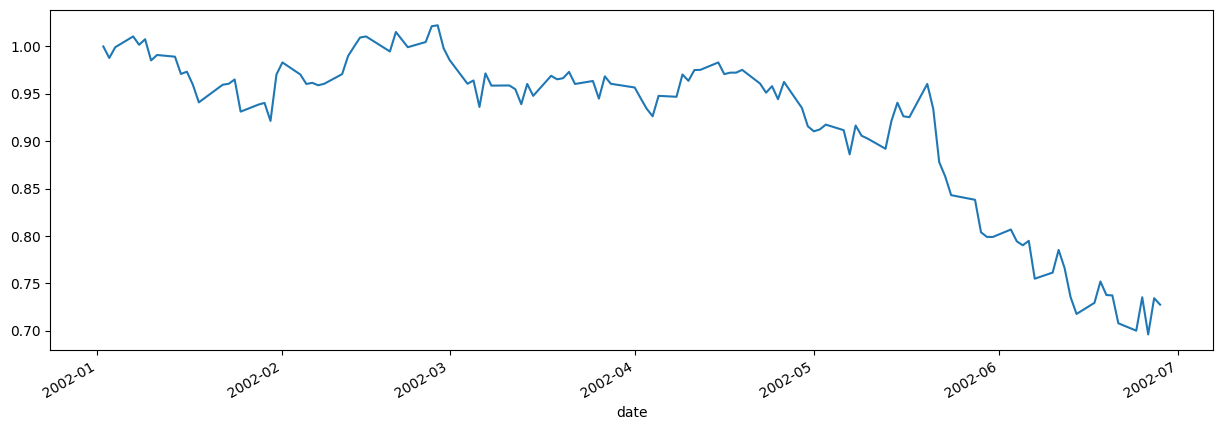

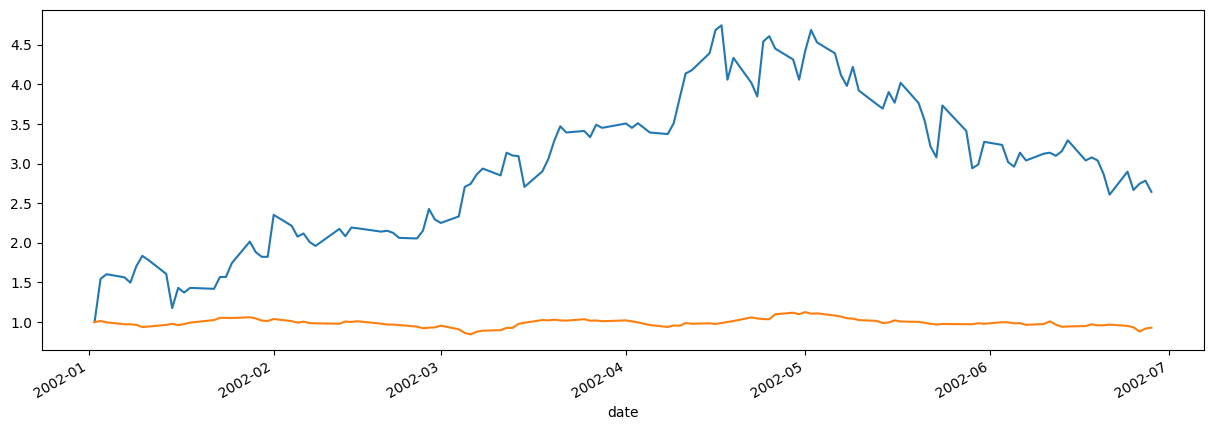

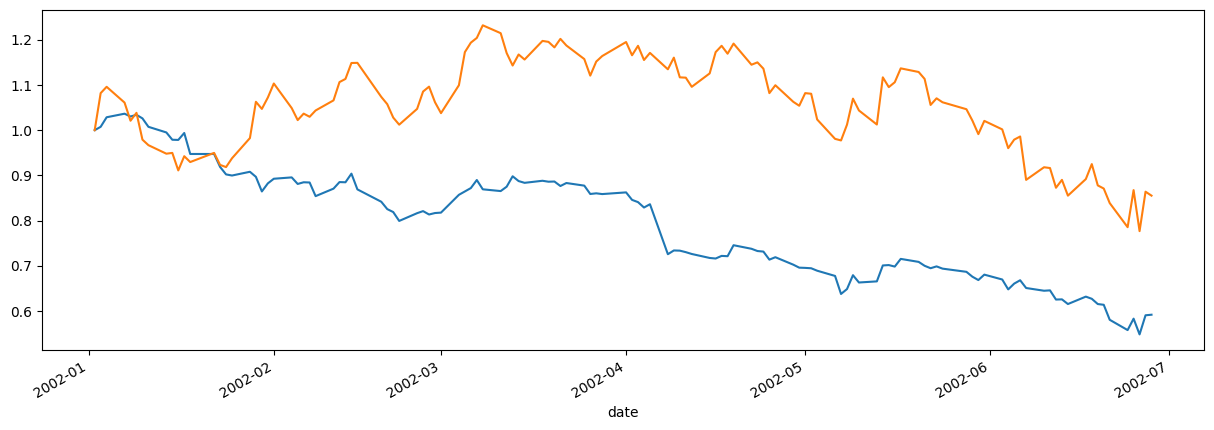

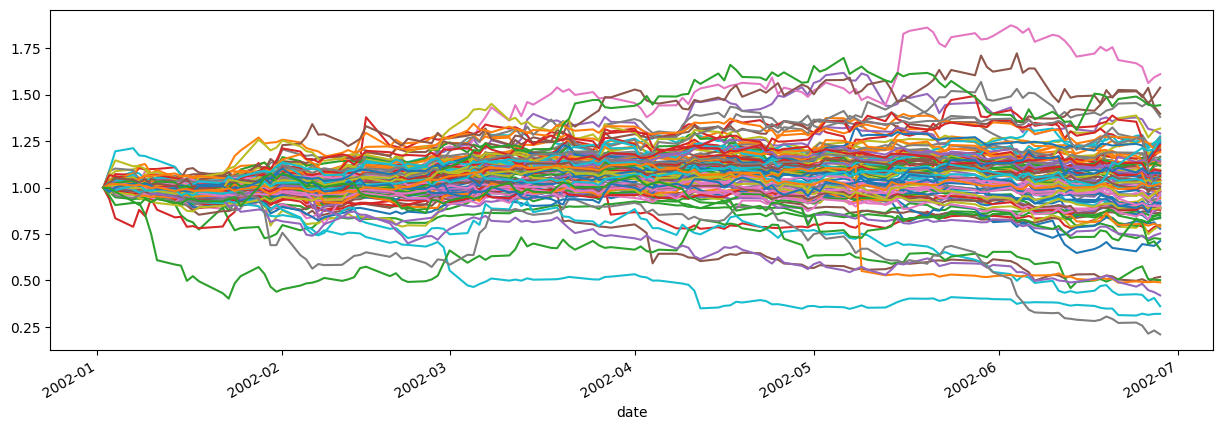

In [120]:
for i in range(len(cluster)):
    print(f"{i}th cluster: {len(cluster.iloc[i])}")
    prices_norm[cluster.iloc[i]].plot(legend = False, figsize=(15,5))

# Testing on Sample

In [135]:
sample = prices[cluster.iloc[2]]
train = sample.iloc[:int(len(sample)*0.5)]
test = sample.iloc[int(len(sample)*0.5):]

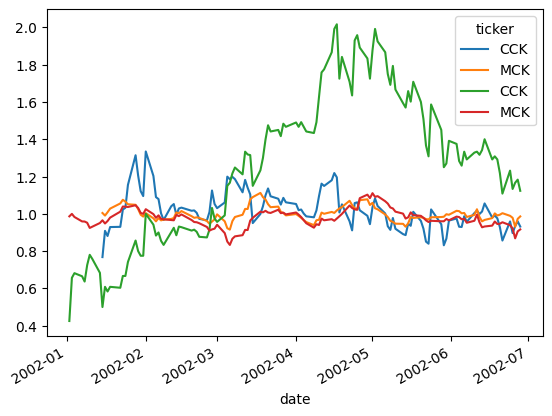

In [149]:
model = sm.OLS(train.iloc[:,0], train.iloc[:,1:]).fit()
coint_pair = sample * [1, model.params[0]]
ax = (sample / sample.rolling(10).mean()).plot( )
(coint_pair / 6).plot(ax = ax, legend = True)
plt.show()

In [198]:
ratio = [1, -model.params[0]]
train_spread = train @ ratio

s = train_spread.std()
m = train_spread.mean()

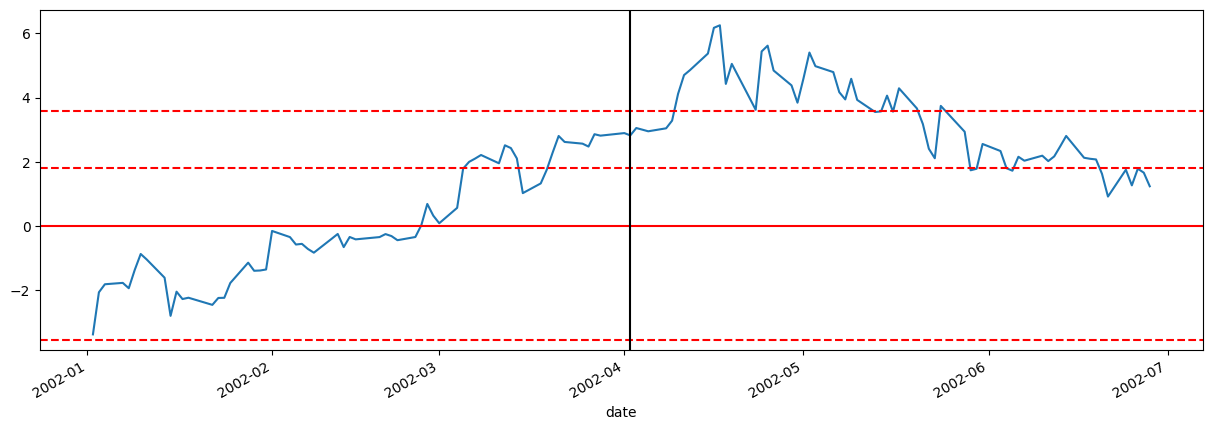

In [334]:
fig = plt.figure(figsize=(15,5))
ax = spread.plot()
ax.axhline(m, color='r')
ax.axhline(m+2*s, color='r', linestyle='--')
ax.axhline(m+s, color='r', linestyle='--')
ax.axhline(m-2*s, color='r', linestyle='--')
ax.axvline(train.index[-1], color='k')

In [193]:
test_spread = test @ ratio

In [213]:
position = (test_spread > (m + 2*s)).astype(int)

<Axes: xlabel='date'>

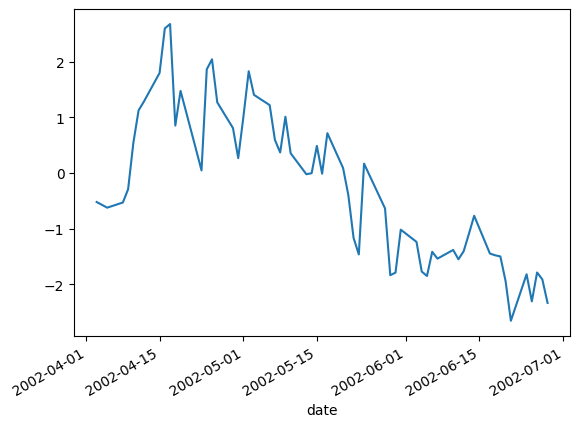

In [218]:
(test_spread - (m + 2*s)).plot()

### PNL Plot

In [379]:
data_gen = lt.DataPreparation(sample.values, sample.columns, train.index, test.index, dates = sample.index)
x_train, y_train, x_test, y_test = data_gen.split_xy(sample.values)

In [380]:
ls = lt.LinearSignal(x_train, y_train, x_test, y_test, sample.columns)
cumm_pnl = ls.get_cumm_pnl()

<Axes: xlabel='date'>

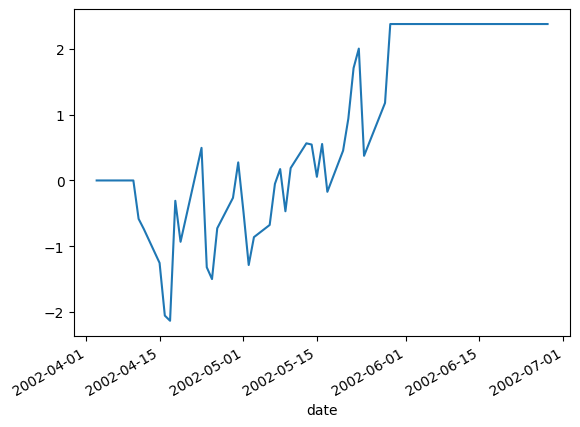

In [381]:
pd.Series(cumm_pnl, data_gen.dates[62:]).plot()

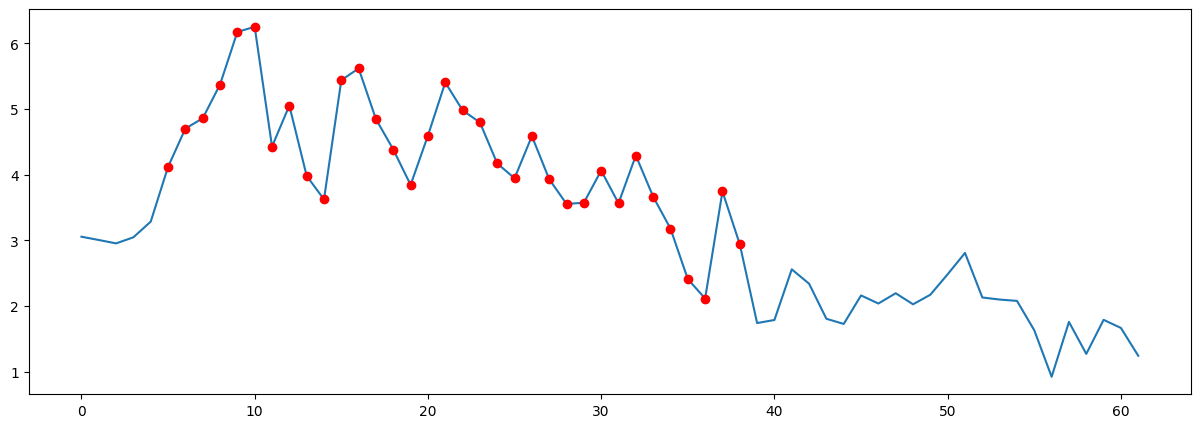

In [372]:
long = np.where(ls.positions == -1)
fig = plt.figure(figsize=(15,5))
plt.plot(ls.spread)
plt.plot(long[0], ls.spread[long], 'o', color='r')